In [1]:
import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots

import statsmodels.api as sm

from statsmodels.stats.outliers_influence \
     import variance_inflation_factor as VIF
from statsmodels.stats.anova import anova_lm

from ISLP import load_data
from ISLP.models import (ModelSpec as MS,
                         summarize,
                         poly)

import math

### Question 8

In [3]:
auto = pd.read_csv('Auto.csv', na_values="?")
auto = auto.dropna()

In [4]:
y=auto['mpg']

design=MS(['horsepower'])
X=design.fit_transform(auto)

auto_slr=sm.OLS(y,X)
results_auto_slr=auto_slr.fit()
summarize(results_auto_slr)

,coef,std err,t,P>|t|
intercept,39.9359,0.717,55.660,0.0
horsepower,-0.1578,0.006,-24.489,0.0


There is a relationship! Yay!
Standard error is super low, meaning almost all of the variance can be explained by the model.
The relationship is negative

In [6]:
new_df = pd.DataFrame({'horsepower':[98]})
newX = design.transform(new_df)
newX

,intercept,horsepower
0,1.0,98


In [7]:
auto_slr_pred = results_auto_slr.get_prediction(newX)
auto_slr_pred.conf_int(alpha=0.05) #CI

array([[23.97307896, 24.96107534]])

In [8]:
auto_slr_pred.conf_int(obs=True, alpha=0.05) #PI

array([[14.80939607, 34.12475823]])

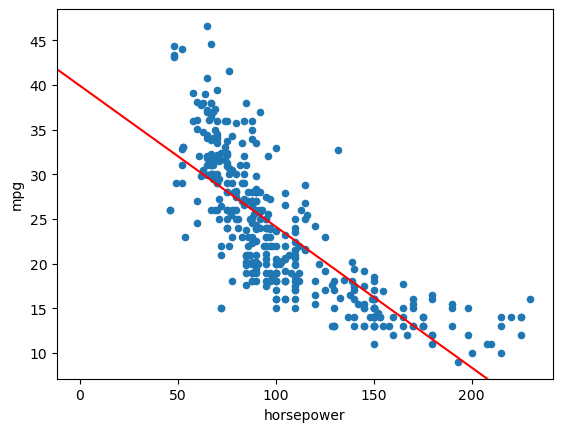

In [9]:
ax = auto.plot.scatter('horsepower', 'mpg')
ax.axline((0,results_auto_slr.params.iloc[0]),slope=results_auto_slr.params.iloc[1],color='r');

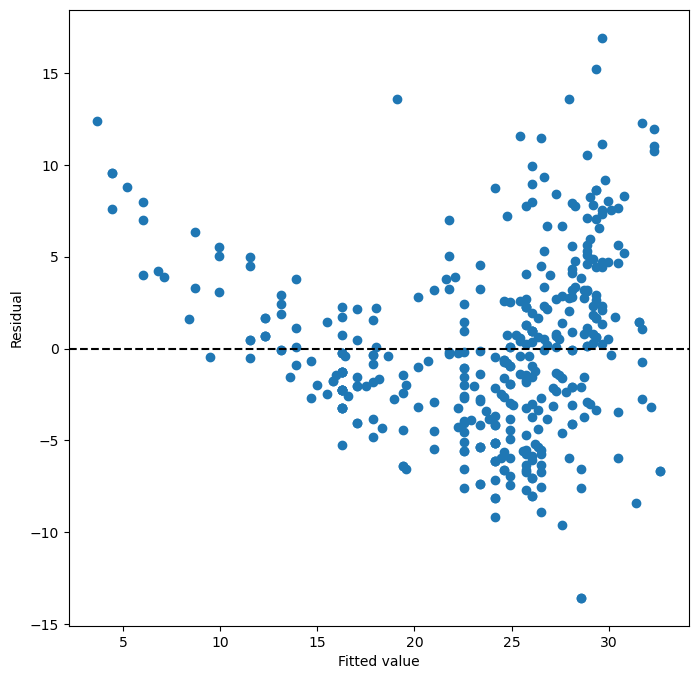

In [10]:
ax = subplots(figsize=(8,8))[1]
ax.scatter(results_auto_slr.fittedvalues, results_auto_slr.resid)
ax.set_xlabel('Fitted value')
ax.set_ylabel('Residual')
ax.axhline(0, c='k', ls='--');

Text(0, 0.5, 'Leverage')

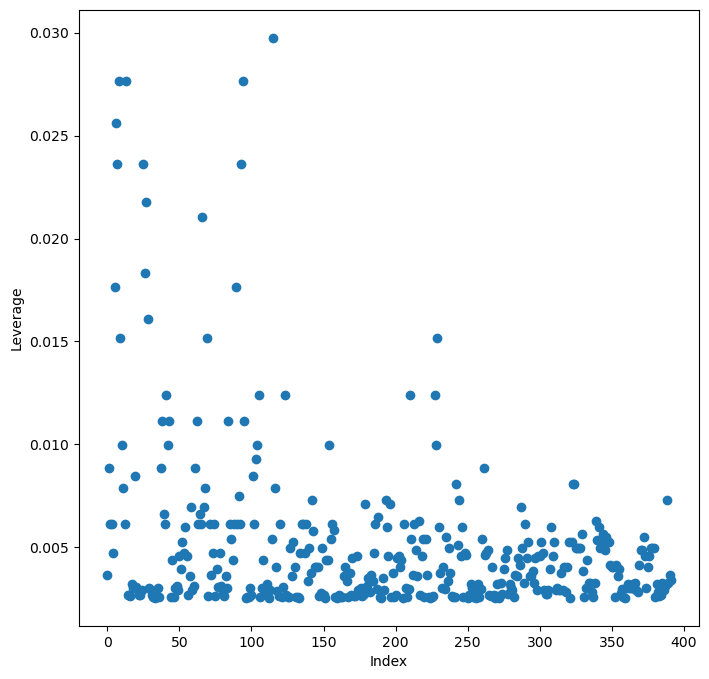

In [11]:
infl = results_auto_slr.get_influence()
ax = subplots(figsize=(8,8))[1]
ax.scatter(np.arange(X.shape[0]), infl.hat_matrix_diag)
ax.set_xlabel('Index')
ax.set_ylabel('Leverage')

In [12]:
auto.shape

(392, 9)

In [13]:
2/392

0.00510204081632653

A few problems: the data doesn't appear to follow a linear relationship from a visual check. The residual plot appears to take on a funnel shape, indiciating heteroscedasticity. Further, there are many points that have high leverage (the positive cutoff being 0.005).

Good next steps would be to consider a non-linear model and/or transforming mpg with a concave function. I have a feeling a polymonial would fit rather nicely.

### Question 9

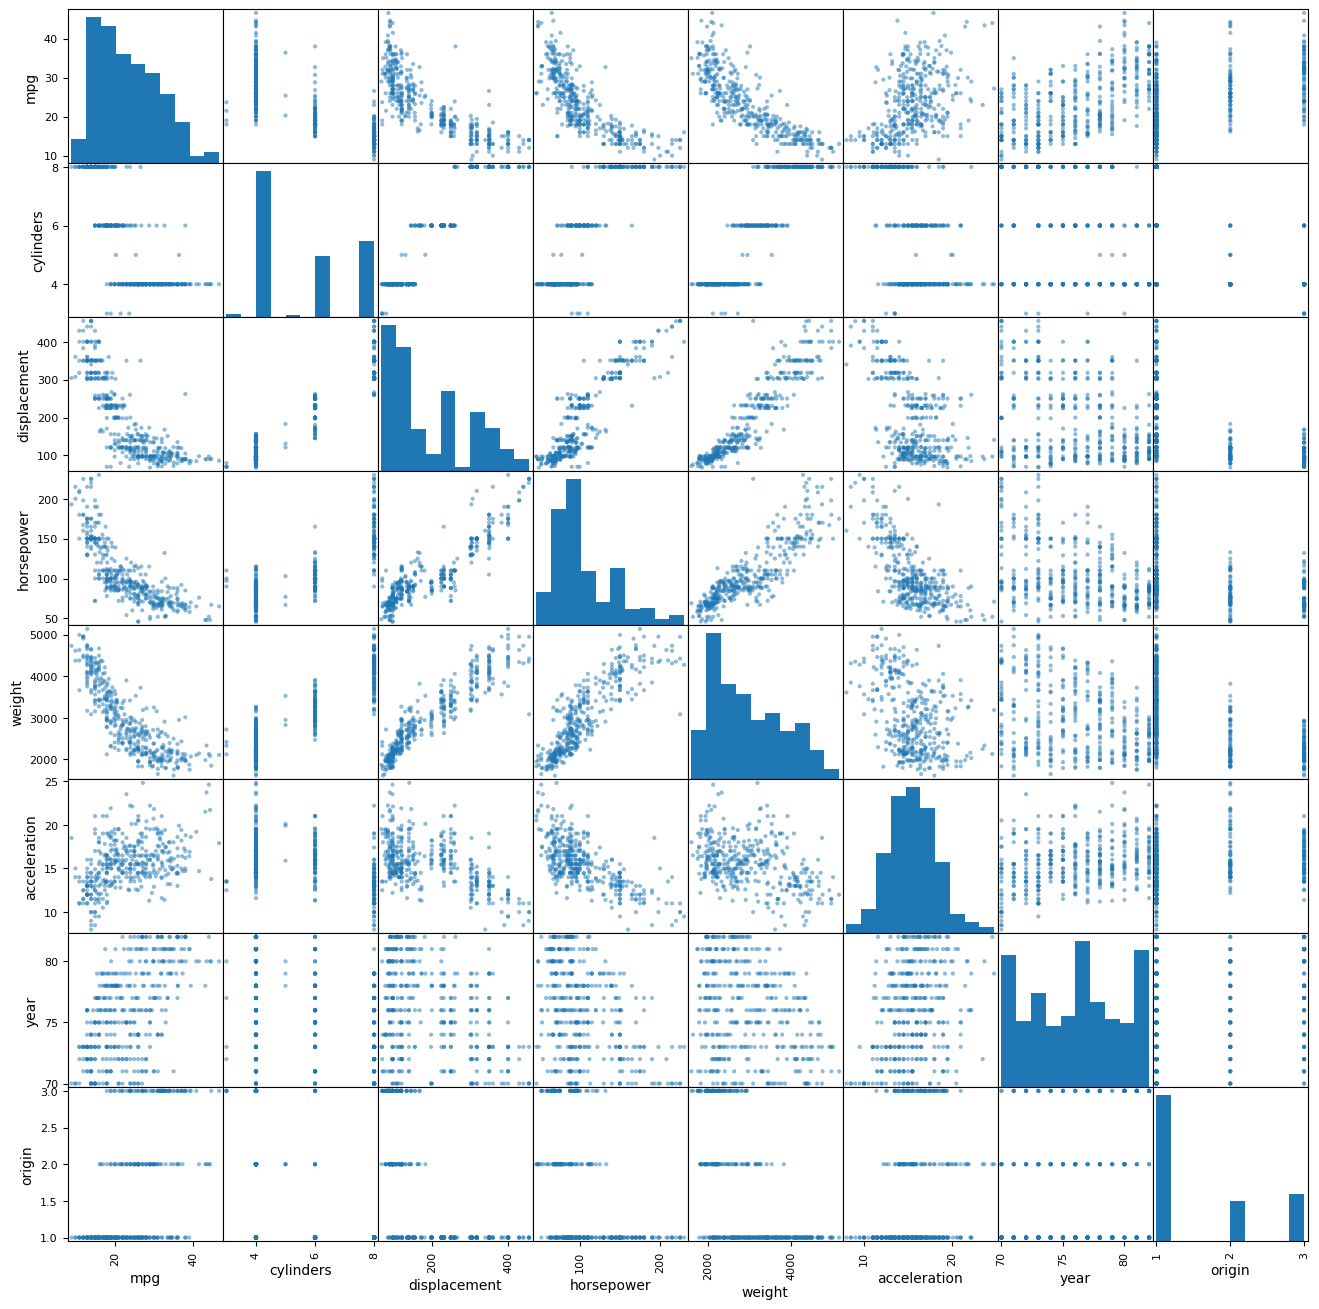

In [16]:
pd.plotting.scatter_matrix(auto,figsize=(16,16));

In [17]:
auto_quant = auto.drop(['name'],axis=1)
auto_quant.corr()

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin
mpg,1.000000,-0.777618,-0.805127,-0.778427,-0.832244,0.423329,0.580541,0.565209
cylinders,-0.777618,1.000000,0.950823,0.842983,0.897527,-0.504683,-0.345647,-0.568932
displacement,-0.805127,0.950823,1.000000,0.897257,0.932994,-0.543800,-0.369855,-0.614535
horsepower,-0.778427,0.842983,0.897257,1.000000,0.864538,-0.689196,-0.416361,-0.455171
weight,-0.832244,0.897527,0.932994,0.864538,1.000000,-0.416839,-0.309120,-0.585005
acceleration,0.423329,-0.504683,-0.543800,-0.689196,-0.416839,1.000000,0.290316,0.212746
year,0.580541,-0.345647,-0.369855,-0.416361,-0.309120,0.290316,1.000000,0.181528
origin,0.565209,-0.568932,-0.614535,-0.455171,-0.585005,0.212746,0.181528,1.000000


In [18]:
X2 = MS(auto_quant.columns.drop('mpg')).fit_transform(auto)
auto_mlr=sm.OLS(y,X2)
results_auto_mlr=auto_mlr.fit()
summarize(results_auto_mlr)

,coef,std err,t,P>|t|
intercept,-17.2184,4.644,-3.707,0.000
cylinders,-0.4934,0.323,-1.526,0.128
displacement,0.0199,0.008,2.647,0.008
horsepower,-0.0170,0.014,-1.230,0.220
weight,-0.0065,0.001,-9.929,0.000
acceleration,0.0806,0.099,0.815,0.415
year,0.7508,0.051,14.729,0.000
origin,1.4261,0.278,5.127,0.000


In [19]:
df = anova_lm(*[sm.OLS(y, D).fit() for D in design.build_sequence(auto, anova_type='sequential')])
df.index = design.names
df

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
intercept,391.0,23818.993469,0.0,NaN,NaN,NaN
horsepower,390.0,9385.915872,1.0,14433.077597,599.717741,7.031989e-81


In [20]:
D_full = design.transform(auto)
OLS_full = sm.OLS(y, D_full).fit()
dfs = []
for d in design.build_sequence(auto, anova_type='drop'):
    dfs.append(anova_lm(sm.OLS(y,d).fit(), OLS_full).iloc[1:])
df = pd.concat(dfs)
df.index = design.names
df

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
intercept,390.0,9385.915872,1.0,74558.295606,3098.017890,1.220362e-187
horsepower,390.0,9385.915872,1.0,14433.077597,599.717741,7.031989e-81


It appears only horsepower has a relationship with mpg. Nothing else impacts mpg enough for consideration. Based on forwards and backwards selection.

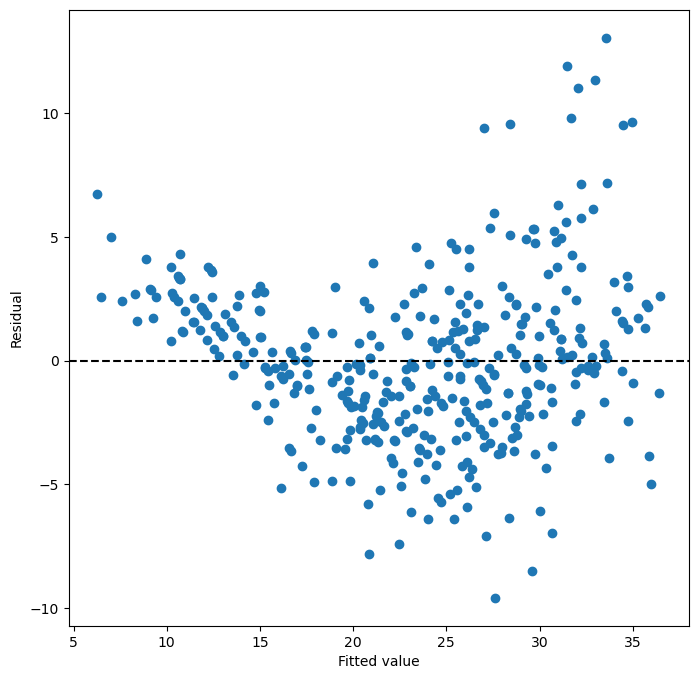

In [22]:
ax = subplots(figsize=(8,8))[1]
ax.scatter(results_auto_mlr.fittedvalues, results_auto_mlr.resid)
ax.set_xlabel('Fitted value')
ax.set_ylabel('Residual')
ax.axhline(0, c='k', ls='--');

Text(0, 0.5, 'Leverage')

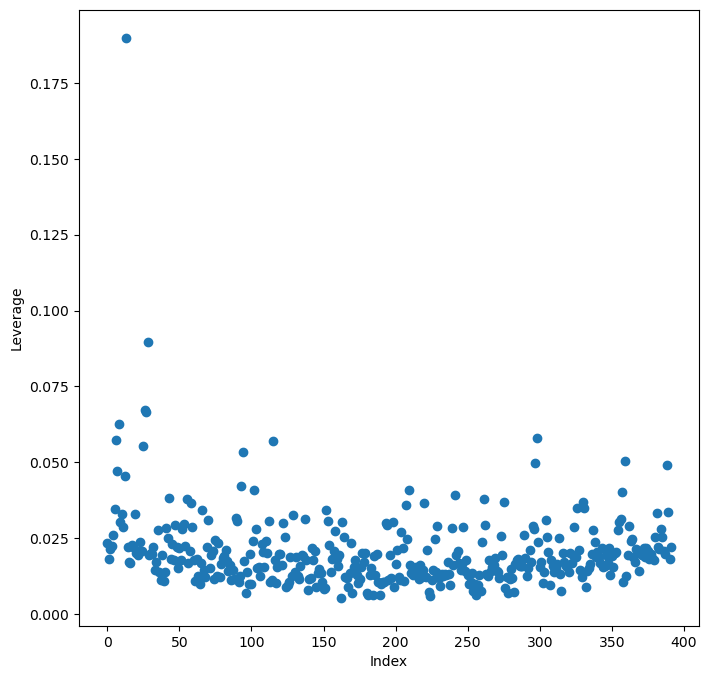

In [23]:
infl = results_auto_mlr.get_influence()
ax = subplots(figsize=(8,8))[1]
ax.scatter(np.arange(X.shape[0]), infl.hat_matrix_diag)
ax.set_xlabel('Index')
ax.set_ylabel('Leverage')

Residuals still indicate heteroscedasticity, and there's still a few high leverage points but it's improved compared to a simple linear model.

There doesn't appear to be any value in building a model with interaction terms, but I'll do it for the practice as the exercises ask.

In [25]:
X3 = MS(['horsepower',
        'weight',
        ('horsepower', 'weight')]).fit_transform(X2)
auto_int=sm.OLS(y,X3)
results_auto_int=auto_int.fit()
summarize(results_auto_int)

,coef,std err,t,P>|t|
intercept,63.557900,2.343000,27.127,0.0
horsepower,-0.250800,0.027000,-9.195,0.0
weight,-0.010800,0.001000,-13.921,0.0
horsepower:weight,0.000054,0.000007,8.054,0.0


In [26]:
results_auto_int.rsquared

0.748435145025321

In [27]:
results_auto_mlr.rsquared

0.8214780764810597

In [28]:
results_auto_slr.rsquared

0.6059482578894348

The multiple linear regression explains more variance than using interaction terms. I'm not convinced the interaction terms are doing much of anything here.

In [30]:
X4 = MS([poly('horsepower', degree=2)]).fit_transform(X2)
auto_x2=sm.OLS(y,X4)
results_auto_x2=auto_x2.fit()
summarize(results_auto_x2)

,coef,std err,t,P>|t|
intercept,23.4459,0.221,106.130,0.0
"poly(horsepower, degree=2)[0]",-120.1377,4.374,-27.467,0.0
"poly(horsepower, degree=2)[1]",44.0895,4.374,10.080,0.0


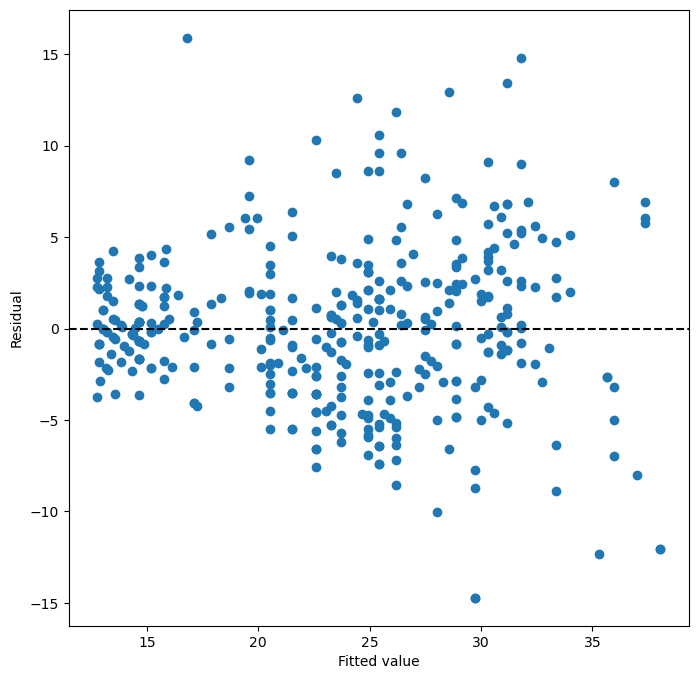

In [31]:
ax = subplots(figsize=(8,8))[1]
ax.scatter(results_auto_x2.fittedvalues, results_auto_x2.resid)
ax.set_xlabel('Fitted value')
ax.set_ylabel('Residual')
ax.axhline(0, c='k', ls='--');

Text(0, 0.5, 'Leverage')

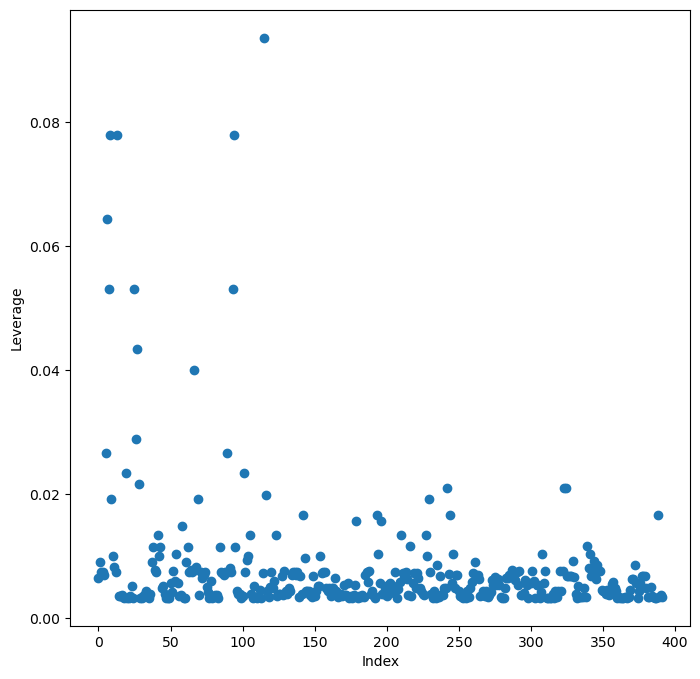

In [32]:
infl = results_auto_x2.get_influence()
ax = subplots(figsize=(8,8))[1]
ax.scatter(np.arange(X.shape[0]), infl.hat_matrix_diag)
ax.set_xlabel('Index')
ax.set_ylabel('Leverage')

squaring horsepower added leverage points but kinda corrected residuals?

In [34]:
Xsqrt = pd.DataFrame(np.sqrt(X2['horsepower']))

In [35]:
X5 = MS(['horsepower']).fit_transform(Xsqrt)
auto_sqrt=sm.OLS(y,X5)
results_auto_sqrt=auto_sqrt.fit()
summarize(results_auto_sqrt)

,coef,std err,t,P>|t|
intercept,58.7052,1.349,43.516,0.0
horsepower,-3.5035,0.132,-26.544,0.0


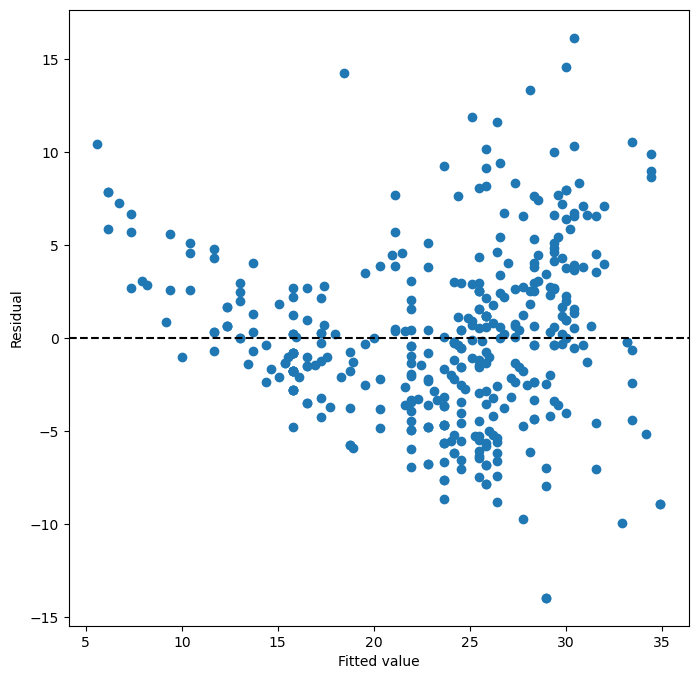

In [36]:
ax = subplots(figsize=(8,8))[1]
ax.scatter(results_auto_sqrt.fittedvalues, results_auto_sqrt.resid)
ax.set_xlabel('Fitted value')
ax.set_ylabel('Residual')
ax.axhline(0, c='k', ls='--');

Text(0, 0.5, 'Leverage')

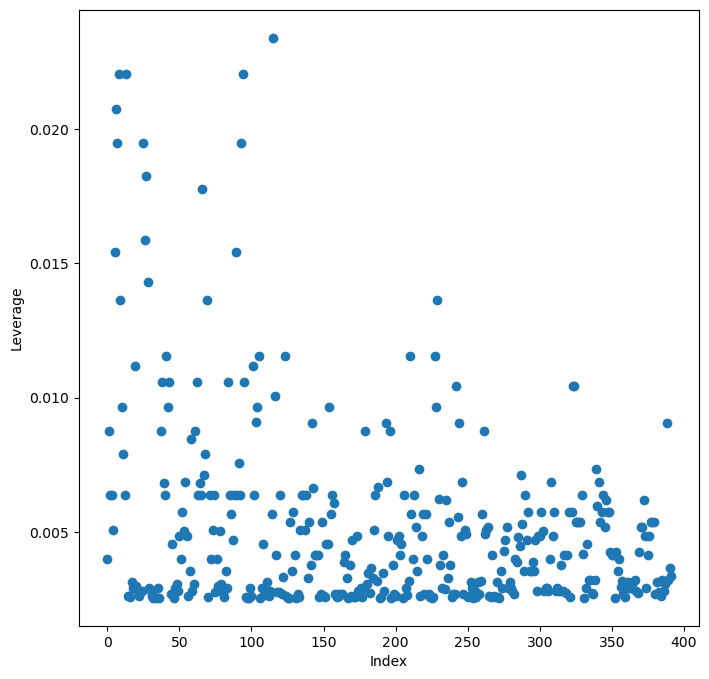

In [37]:
infl = results_auto_sqrt.get_influence()
ax = subplots(figsize=(8,8))[1]
ax.scatter(np.arange(X.shape[0]), infl.hat_matrix_diag)
ax.set_xlabel('Index')
ax.set_ylabel('Leverage')

square root didn't fix heteroscedasticity and mad eleverage points worse oops

In [39]:
Xlog = pd.DataFrame(np.log(X2['horsepower']))

In [40]:
X6 = MS(['horsepower']).fit_transform(Xlog)
auto_log=sm.OLS(y,X6)
results_auto_log=auto_log.fit()
summarize(results_auto_log)

,coef,std err,t,P>|t|
intercept,108.6997,3.050,35.644,0.0
horsepower,-18.5822,0.663,-28.034,0.0


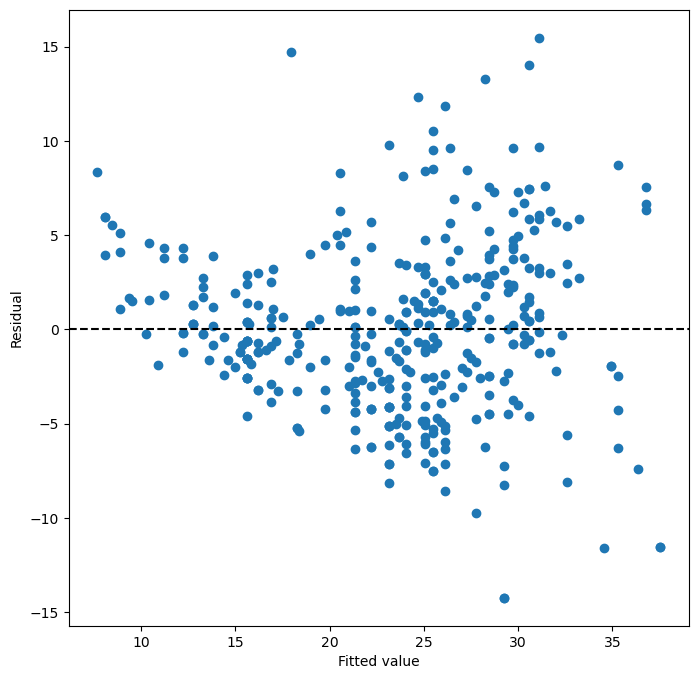

In [41]:
ax = subplots(figsize=(8,8))[1]
ax.scatter(results_auto_log.fittedvalues, results_auto_log.resid)
ax.set_xlabel('Fitted value')
ax.set_ylabel('Residual')
ax.axhline(0, c='k', ls='--');

Text(0, 0.5, 'Leverage')

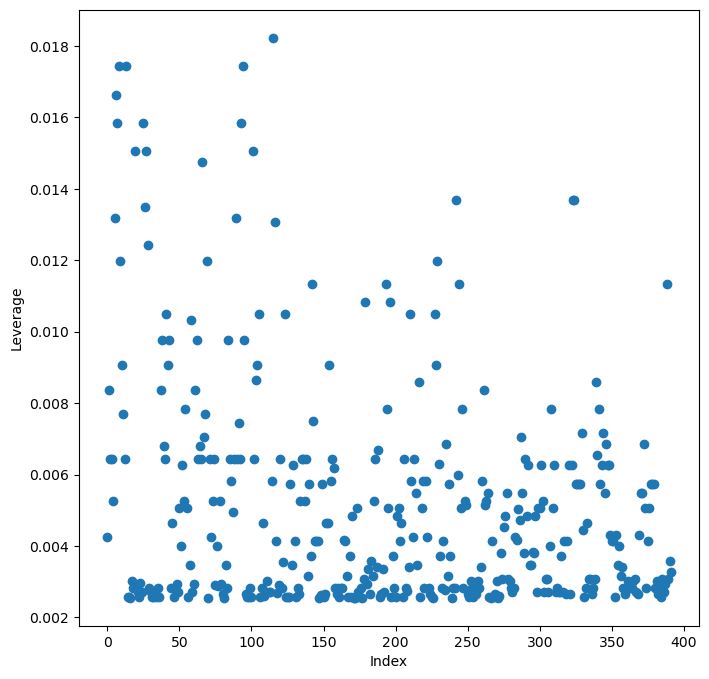

In [42]:
infl = results_auto_log.get_influence()
ax = subplots(figsize=(8,8))[1]
ax.scatter(np.arange(X.shape[0]), infl.hat_matrix_diag)
ax.set_xlabel('Index')
ax.set_ylabel('Leverage')

how did log make leverage even worse? And there's still heteroscedasticity! ugh.

### Question 10

In [45]:
carseats = pd.read_csv('Carseats.csv')
y = carseats['Sales']
carseats = pd.DataFrame(carseats[['Price','Urban','US']])
carseats['Urban'] = carseats['Urban'].astype("category")
carseats['US'] = carseats['US'].astype("category")

In [46]:
X = MS(carseats.columns).fit_transform(carseats)
cs_a = sm.OLS(y, X)
results_cs_a = cs_a.fit()
summarize(results_cs_a)

,coef,std err,t,P>|t|
intercept,13.0435,0.651,20.036,0.000
Price,-0.0545,0.005,-10.389,0.000
Urban[Yes],-0.0219,0.272,-0.081,0.936
US[Yes],1.2006,0.259,4.635,0.000


$$Sales=13.0435-0.0545Price-0.0219Urban+1.2006US+\epsilon$$

We can reject the null hypothesis for price and US, but not for urban.

In [49]:
carseats2 = pd.DataFrame(carseats[['Price','US']])
carseats['US'] = carseats['US'].astype("category")

In [50]:
X2 = MS(carseats2.columns).fit_transform(carseats2)
cs_e = sm.OLS(y, X2)
results_cs_e = cs_e.fit()
summarize(results_cs_e)

,coef,std err,t,P>|t|
intercept,13.0308,0.631,20.652,0.0
Price,-0.0545,0.005,-10.416,0.0
US[Yes],1.1996,0.258,4.641,0.0


In [51]:
results_cs_a.rsquared

0.23927539218405525

In [52]:
results_cs_e.rsquared

0.23926288842678567

The models fit the data very similarly, with A being sligtly better due to the added predictor. E is better with less predictors.

In [54]:
results_cs_e.conf_int(alpha=0.05)

,0,1
intercept,11.79032,14.271265
Price,-0.06476,-0.044195
US[Yes],0.69152,1.707766


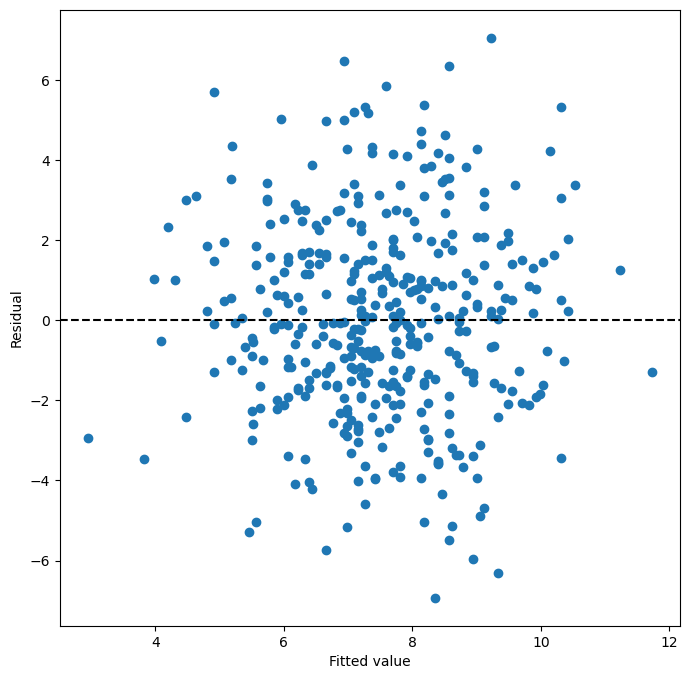

In [55]:
ax = subplots(figsize=(8,8))[1]
ax.scatter(results_cs_e.fittedvalues, results_cs_e.resid)
ax.set_xlabel('Fitted value')
ax.set_ylabel('Residual')
ax.axhline(0, c='k', ls='--');

Text(0, 0.5, 'Leverage')

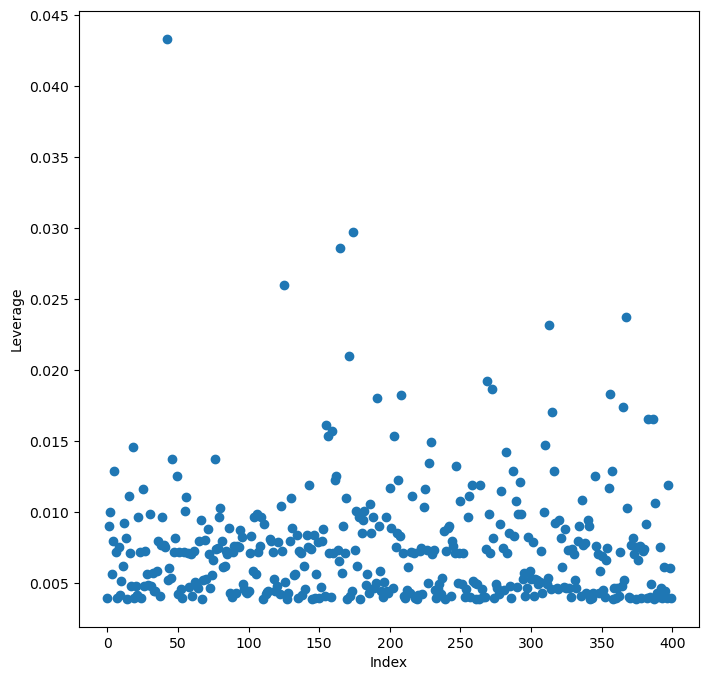

In [56]:
infl = results_cs_e.get_influence()
ax = subplots(figsize=(8,8))[1]
ax.scatter(np.arange(X.shape[0]), infl.hat_matrix_diag)
ax.set_xlabel('Index')
ax.set_ylabel('Leverage')

There are quite a few outliers and leverage points.